## Machine Learning Model
## Wine Reviews Analysis: Can the quality of wine be predicted?

## Exploring the Data
Most of explanatory analysis was performed in wine-analysis.ipynb file

In [103]:
#import libraries here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
import re
from PIL import Image
from IPython.display import Image as im
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


%matplotlib inline

In [6]:
#read data to DataFrame
wine_main = pd.read_csv('winemag-data-130k-v2.csv')

# TODO: Total number of records
n_records = wine_main.shape[0]
n_features = wine_main.shape[1]

# Print the results
print("Total number of records: {}".format(n_records))
print("Total number of features: {}".format(n_features))

wine_main.head()

Total number of records: 129971
Total number of features: 14


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


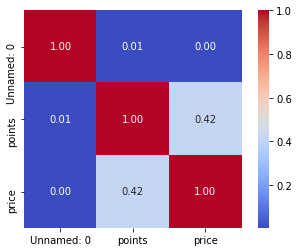

In [5]:
#plot correlation between features
sns.heatmap(wine_main.corr(), annot=True, fmt='.2f', cmap="coolwarm", square=True)

** Featureset Exploration **

* **Unnamed**: can be deleted. 
* **country**: country of wine (categorical). 
* **description**: description of wine given by taster. 
* **designation**: categorical. 
* **points**: rating of wine quality (continuous 0-100)
* **price**: continuous. 
* **province**: categorical. 
* **region_1**: categorical. 
* **region_2**: categorical (a lot of missing values). 
* **taster_name**: categorical. 
* **taster_twitter_handle**: categorical. 
* **title**: Title of wine that contains such information as year, sparkling, vintage. 
* **variety**: categorical.
* **winery**: categorical.

----
## Preprocessing data##
### Assess Missing Data###

region_2                 61.14
designation              28.83
taster_twitter_handle    24.02
taster_name              20.19
region_1                 16.35
price                     6.92
province                  0.05
country                   0.05
variety                   0.00
winery                    0.00
title                     0.00
points                    0.00
description               0.00
Unnamed: 0                0.00
dtype: float64

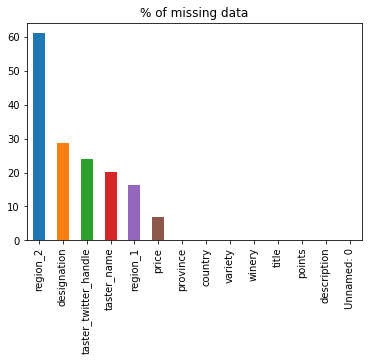

In [7]:
#identify missing data by column
missing_by_columns = wine_main.isnull().mean().sort_values(ascending=False).round(4)*100
missing_by_columns.plot(kind='bar')
plt.title("% of missing data")
missing_by_columns

### Discussion:###
Among the columns with the most missing values are region_2 (%61), designation (%29), taster_twitter_handle (%24) and taster_name (%20). I decided to drop this column.

### Drop Missing Values###

In [8]:
#drop region_2, designation, taster_twitter_handle, taster_name
wine_clmn_reduced = wine_main.drop(columns=["region_2", "designation", "taster_twitter_handle", "taster_name"])
wine_clmn_reduced.head()

,Unnamed: 0,country,description,points,price,province,region_1,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [9]:
#missing by rows
#drop rows with missing price
wine_row_reduced = wine_clmn_reduced.dropna(subset=['price'], how='any')
print(wine_row_reduced.shape)
wine_row_reduced.head()

(120975, 10)


,Unnamed: 0,country,description,points,price,province,region_1,title,variety,winery
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [10]:
#check missing values by column again
wine_row_reduced.isnull().sum().sort_values(ascending=False)

region_1       19575
province          59
country           59
variety            1
winery             0
title              0
price              0
points             0
description        0
Unnamed: 0         0
dtype: int64

In [11]:
#Since country is one of the most important attribute to predict price. We will drop 59 rows with missing country. 
wine_row_reduced = wine_row_reduced.dropna(subset=['country','variety'], how='any')
#check missing values by column again
print("Number of rows, columns:", (wine_row_reduced.shape[0], wine_row_reduced.shape[1]))
wine_row_reduced.isnull().sum().sort_values(ascending=False)

Number of rows, columns: (120915, 10)


region_1       19515
winery             0
variety            0
title              0
province           0
price              0
points             0
description        0
country            0
Unnamed: 0         0
dtype: int64

### Discussion:###
"region_2", "designation", "taster_twitter_handle", "taster_name" were dropped because there are a lot of missing values in them.

Rows with missing "price", "country" and "variety" also were dropped from analysis. 

The missing values in region_1 can simply mean that there is no region which can give important information. This Nan Values need to be imputed with zeros

### Replace missing values Nan by 0###

In [25]:
wine_row_reduced["region_1"].replace(np.nan, 0, inplace=True)
wine_row_reduced.isnull().sum()

Unnamed: 0     0
country        0
description    0
points         0
price          0
province       0
region_1       0
title          0
variety        0
winery         0
dtype: int64

### Process the rows with similar wine title
I will group wine by title, take the mean value for the price and points, take the first entry for country, province, region_1, variety and winery (because all this attributes supposed to be the same for given title), and I will joint descriptions together making a list of available reviews for given wine.

In [26]:
#Lets group by wines by title
wine_groupped = wine_row_reduced.groupby('title').agg(dict(country = 'first', description = list, points = 'mean', price = 'mean', province='first', region_1 = 'first', variety = 'first', winery = 'first')).reset_index()
wine_groupped

,title,country,description,points,price,province,region_1,variety,winery
0,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),Spain,[The previous two years we did not find this w...,82.0,18.0,Catalonia,Penedès,Cabernet Sauvignon,1+1=3
1,1+1=3 NV Brut Sparkling (Cava),Spain,[Spiced apple and toast aromas are clean and d...,87.0,16.0,Catalonia,Cava,Sparkling Blend,1+1=3
2,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Spain,"[Clean, fresh apple aromas and a minerally, ci...",89.0,20.0,Catalonia,Cava,Sparkling Blend,1+1=3
3,1+1=3 NV Rosé Sparkling (Cava),Spain,"[A dusty, yeasty nose is simplistic but friend...",86.0,20.0,Catalonia,Cava,Sparkling Blend,1+1=3
4,10 Knots 2006 Beachcomber White (Paso Robles),US,"[A Rhône blend of Viognier, Roussanne and Mars...",83.0,21.0,California,Paso Robles,Rhône-style White Blend,10 Knots
5,10 Knots 2006 Chardonnay (Santa Barbara County),US,[Oaky influences give this wine a candied tast...,85.0,21.0,California,Santa Barbara County,Chardonnay,10 Knots
6,10 Knots 2009 Moonraker Grenache (Paso Robles),US,"[Hot in alcohol, simple in everything else, th...",81.0,35.0,California,Paso Robles,Grenache,10 Knots
7,10 Knots 2010 Viognier (Paso Robles),US,"[A strongly flavored, sugary, unsubtle wine, l...",84.0,22.0,California,Paso Robles,Viognier,10 Knots
8,100 Percent Wine 2012 All Profits to Charity R...,US,"[Juicy and fresh, this deeply colored wine off...",89.0,18.0,California,California,Red Blend,100 Percent Wine
9,100 Percent Wine 2014 All Profits to Charity S...,US,"[Herbaceous in aroma, dry and lean on the pala...",84.0,18.0,California,California,Sauvignon Blanc,100 Percent Wine


### Feature engineering###
The three new feaures can be extracted from title of wine: "year", "sparkling" and "vintage". 

In [28]:
years1 = wine_groupped['title'].str.extract('([1][9][0-9][0-9])').astype('float64')
years1.fillna(0, inplace=True)
years2 = wine_groupped['title'].str.extract('([2][0][0-1][0-9])').astype('float64')
years2.fillna(0, inplace=True)
years = np.add(years1,years2)
wine_groupped = wine_groupped.assign(year = years)

In [29]:
def add_feature_from_title(df, feature):
    '''
    This function search for listed word in title and add it as a separate feauture (column)
    
    Args:
    df (DataFrame): dataframe with column title
    feature (str): word that wull be searched in title
    
    Returns:
    
    df
    '''
    
    feature_occurrence = df['title'].str.lower().str.find(feature)
    feature_occurrence[feature_occurrence >= 0] = 1
    feature_occurrence[feature_occurrence == -1] = 0

    df[feature] = feature_occurrence
    
    return df

wine_groupped = add_feature_from_title(wine_groupped, "sparkling")
wine_groupped = add_feature_from_title(wine_groupped, "vintage")

In [30]:
#check if there is vintage wine with no year assigned
wine_groupped[wine_groupped["year"]==0][wine_groupped['vintage']==1]

/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,title,country,description,points,price,province,region_1,variety,winery,year,sparkling,vintage
100008,Torre Oria NV Brut Nature Vintage Sparkling (C...,Spain,"[Gassy, bready apple aromas are dull and unfoc...",82.0,13.0,Catalonia,Cava,Sparkling Blend,Torre Oria,0.0,1,1


In [31]:
#Calculate mean of year for sparkling vintage wines
mean_vintage_sparkling = round(wine_groupped[wine_groupped["vintage"]==1][wine_groupped['sparkling']==1]['year'].mean(),0)
mean_vintage_sparkling

/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1966.0

In [32]:
#substitute missing year
index = wine_groupped[wine_groupped["year"]==0][wine_groupped['vintage']==1].index[0]
wine_groupped.set_value(index=index, col='year', value=mean_vintage_sparkling)

/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/maxim/miniconda/envs/Python_36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


,title,country,description,points,price,province,region_1,variety,winery,year,sparkling,vintage
0,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),Spain,[The previous two years we did not find this w...,82.0,18.0,Catalonia,Penedès,Cabernet Sauvignon,1+1=3,2008.0,0,0
1,1+1=3 NV Brut Sparkling (Cava),Spain,[Spiced apple and toast aromas are clean and d...,87.0,16.0,Catalonia,Cava,Sparkling Blend,1+1=3,0.0,1,0
2,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Spain,"[Clean, fresh apple aromas and a minerally, ci...",89.0,20.0,Catalonia,Cava,Sparkling Blend,1+1=3,0.0,1,0
3,1+1=3 NV Rosé Sparkling (Cava),Spain,"[A dusty, yeasty nose is simplistic but friend...",86.0,20.0,Catalonia,Cava,Sparkling Blend,1+1=3,0.0,1,0
4,10 Knots 2006 Beachcomber White (Paso Robles),US,"[A Rhône blend of Viognier, Roussanne and Mars...",83.0,21.0,California,Paso Robles,Rhône-style White Blend,10 Knots,2006.0,0,0
5,10 Knots 2006 Chardonnay (Santa Barbara County),US,[Oaky influences give this wine a candied tast...,85.0,21.0,California,Santa Barbara County,Chardonnay,10 Knots,2006.0,0,0
6,10 Knots 2009 Moonraker Grenache (Paso Robles),US,"[Hot in alcohol, simple in everything else, th...",81.0,35.0,California,Paso Robles,Grenache,10 Knots,2009.0,0,0
7,10 Knots 2010 Viognier (Paso Robles),US,"[A strongly flavored, sugary, unsubtle wine, l...",84.0,22.0,California,Paso Robles,Viognier,10 Knots,2010.0,0,0
8,100 Percent Wine 2012 All Profits to Charity R...,US,"[Juicy and fresh, this deeply colored wine off...",89.0,18.0,California,California,Red Blend,100 Percent Wine,2012.0,0,0
9,100 Percent Wine 2014 All Profits to Charity S...,US,"[Herbaceous in aroma, dry and lean on the pala...",84.0,18.0,California,California,Sauvignon Blanc,100 Percent Wine,2014.0,0,0


In [33]:
#now assign the latest year for all 0 year values
wine_groupped['year'].replace(0, 2017, inplace=True)
wine_groupped[:5]

,title,country,description,points,price,province,region_1,variety,winery,year,sparkling,vintage
0,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),Spain,[The previous two years we did not find this w...,82.0,18.0,Catalonia,Penedès,Cabernet Sauvignon,1+1=3,2008.0,0,0
1,1+1=3 NV Brut Sparkling (Cava),Spain,[Spiced apple and toast aromas are clean and d...,87.0,16.0,Catalonia,Cava,Sparkling Blend,1+1=3,2017.0,1,0
2,1+1=3 NV Cygnus Brut Nature Reserva Made With ...,Spain,"[Clean, fresh apple aromas and a minerally, ci...",89.0,20.0,Catalonia,Cava,Sparkling Blend,1+1=3,2017.0,1,0
3,1+1=3 NV Rosé Sparkling (Cava),Spain,"[A dusty, yeasty nose is simplistic but friend...",86.0,20.0,Catalonia,Cava,Sparkling Blend,1+1=3,2017.0,1,0
4,10 Knots 2006 Beachcomber White (Paso Robles),US,"[A Rhône blend of Viognier, Roussanne and Mars...",83.0,21.0,California,Paso Robles,Rhône-style White Blend,10 Knots,2006.0,0,0


### Re-Encode Categorical Features ###

In [35]:
#identify categorical attributes
wine_groupped.dtypes

title           object
country         object
description     object
points         float64
price          float64
province        object
region_1        object
variety         object
winery          object
year           float64
sparkling        int64
vintage          int64
dtype: object

In [38]:
print("Number of countries: ", len(wine_groupped['country'].value_counts()))
print("Number of provinces: ", len(wine_groupped['province'].value_counts()))
print("Number of regions: ", len(wine_groupped['region_1'].value_counts()))
print("Number of varieties: ", len(wine_groupped['variety'].value_counts()))
print("Number of wineries: ", len(wine_groupped['winery'].value_counts()))

df_no_reviews = wine_groupped.drop(['title', 'description', 'winery', 'region_1'], axis=1)

#check later, maybe drop regions (1204), 
#decided to drop regions

# Re-encode categorical features to be kept in the analysis.
reencode_categ = ['country', 'province', 'variety']
reencoded_wines = pd.get_dummies(df_no_reviews, columns=reencode_categ, drop_first=True)
print(df_no_reviews.shape)
print(reencoded_wines.shape)

Number of countries:  42
Number of provinces:  422
Number of regions:  1205
Number of varieties:  691
Number of wineries:  15843
(110582, 8)
(110582, 1157)


### Discussion###
'title', 'description', 'winery', 'region_1' were dropped from analysis because of many categorical values.

'country', 'province', 'variety' were processed using **one-hot encoding** scheme.

## Create Cleaning Function##

In [47]:
wine_cleaned = reencoded_wines.copy()

In [ ]:
#check whether all columns are of numeric dtype
for column in reencoded_wines.columns:
    if pd.api.types.is_numeric_dtype(reencoded_wines[column])==False:
        print(column)
        print(reencoded_wines[column])
                                
#check missing values
missing = reencoded_wines.isnull().sum(axis=0).sort_values(ascending=False)
print(missing[:5])


## Split data into target and features ##

Since I would like to predict the quality of wine I separate the column "points" into target "y"

In [48]:
quality = wine_cleaned["points"]
features = wine_cleaned.drop(["points"], axis=1)

## Normalizing Numerical Features ##
Normalization ensures that each feature is treated equally when applying supervised learners. 


In [49]:
# Initialize a scaler, then apply it to the features
scaler = StandardScaler() # default=(0, 1)
numerical = ['price', 'year']

features[:] = scaler.fit_transform(features[:])

# Show an example of a record with scaling applied
display(features.head(n = 5))

,price,year,sparkling,vintage,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,...,variety_Xynisteri,variety_Yapincak,variety_Zibibbo,variety_Zierfandler,variety_Zierfandler-Rotgipfler,variety_Zinfandel,variety_Zlahtina,variety_Zweigelt,variety_Çalkarası,variety_Žilavka
0,-0.421405,-0.083607,-0.123866,-0.061078,-0.004253,-0.140979,-0.152926,-0.004253,-0.019951,-0.03457,...,-0.004253,-0.004253,-0.015038,-0.009974,-0.006014,-0.152647,-0.004253,-0.037827,-0.004253,-0.003007
1,-0.469307,0.105233,8.073236,-0.061078,-0.004253,-0.140979,-0.152926,-0.004253,-0.019951,-0.03457,...,-0.004253,-0.004253,-0.015038,-0.009974,-0.006014,-0.152647,-0.004253,-0.037827,-0.004253,-0.003007
2,-0.373502,0.105233,8.073236,-0.061078,-0.004253,-0.140979,-0.152926,-0.004253,-0.019951,-0.03457,...,-0.004253,-0.004253,-0.015038,-0.009974,-0.006014,-0.152647,-0.004253,-0.037827,-0.004253,-0.003007
3,-0.373502,0.105233,8.073236,-0.061078,-0.004253,-0.140979,-0.152926,-0.004253,-0.019951,-0.03457,...,-0.004253,-0.004253,-0.015038,-0.009974,-0.006014,-0.152647,-0.004253,-0.037827,-0.004253,-0.003007
4,-0.349551,-0.125571,-0.123866,-0.061078,-0.004253,-0.140979,-0.152926,-0.004253,-0.019951,-0.03457,...,-0.004253,-0.004253,-0.015038,-0.009974,-0.006014,-0.152647,-0.004253,-0.037827,-0.004253,-0.003007


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [50]:
quality = y
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    quality, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 88465 samples.
Testing set has 22117 samples.


----
## Evaluating Model Performance
In this section, three algorithms were investigated and determined which is best at modeling the data.

###  Supervised Learning Models
**The following supervised learning models are used** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):
- Linear Regression
- Ensemble Methods: Random Forest
- Ensemble Methods: AdaBoost
- Ensemble Methods: Gradient Boosting


### Implementation: Initial Model Evaluation


In [82]:
#Initialize the three models
linear_model = LinearRegression()
forest_model = RandomForestRegressor(random_state=42)
ada_model = AdaBoostRegressor(random_state=42)
gboost_model = GradientBoostingRegressor(random_state=42)


In [83]:
def evaluate_model(model):
    '''Evaluate model based on r2 score, mean squared error of training and test sets
    
    Input: model
    Return: dictionary with scores
    
    '''
    model = model.fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    results = {}
    results['train_r2_score'] = r2_score(y_train, predict_train)
    results['test_r2_score'] = r2_score(y_test, predict_test)
    results['train_mse'] = mean_squared_error(y_train, predict_train)
    results['test_mse'] = mean_squared_error(y_test, predict_test)

    return results

In [84]:
for model in [gboost_model, linear_model, forest_model, ada_model]:
    results = evaluate_model(model)
    print(model)
    print(results)
    

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)
{'train_r2_score': 0.45965842108588739, 'test_r2_score': 0.452579121035945, 'train_mse': 5.1813091371293121, 'test_mse': 5.2902278975144768}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
{'train_r2_score': 0.27785608679973162, 'test_r2_score': -4.8015340382540088e+27, 'train_mse': 6.9246028841722795, 'test_mse': 4.6401608517574655e+28}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_spl

### Discussion:###
Based on the r2_score and mean_squared_error, the most successful classifier on the testing set is Gradient Boosting regressor, which has the following metrics on the test set: r2_Score = 0.45 and mean_squared_Error=5.53.


----
## Improving Results
Grid search optimization was performed for Gradient Bossting Regressor by tuning at parameters to improve upon the untuned model's r2_score.

In [89]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#Initialize the classifier
gboost_model = GradientBoostingRegressor(random_state=42)

#Create the parameters list you wish to tune, using a dictionary if needed.
#parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'loss': ['ls'], 'learning_rate': [0.1, 0.2],
             'n_estimators': [100], 'max_depth': [3, 5, 7], 'min_samples_split': [4, 6]}

#Make an r2_score scoring object using make_scorer()
scorer = make_scorer(r2_score)

# Perform grid search on the regressor using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(gboost_model, parameters, scoring = scorer)

#Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_model = grid_fit.best_estimator_
print(best_model)


print("\nOptimized Model\n------")
print("Final r2 score on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))
print("Final MSE on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Optimized Model
------


NameError: name 'best_predictions' is not defined

In [90]:
best_predictions = best_model.predict(X_test)


In [91]:
print("\nOptimized Model\n------")
print("Final r2 score on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))
print("Final MSE on the testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)))


Optimized Model
------
Final r2 score on the testing data: 0.4882
Final MSE on the testing data: 4.9463


In [92]:
display(grid_obj.best_params_)

{'learning_rate': 0.2,
 'loss': 'ls',
 'max_depth': 7,
 'min_samples_split': 4,
 'n_estimators': 100}

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| r2 score       |     0.45          |   0.49       |
| MSE            |     5.53          |   4.94       |


Text(0.5,1,'Predicted vs Actual quality, points')

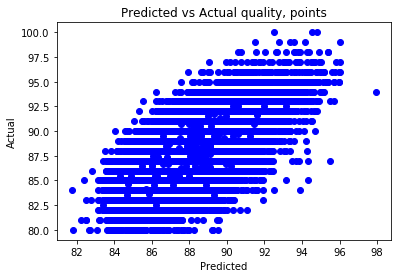

In [93]:
plt.plot(best_predictions, y_test, 'bo');
plt.xlabel('Predicted');
plt.ylabel('Actual')
plt.title('Predicted vs Actual quality, points')

----
## Feature Importance

An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. 


In [95]:
#Extract the feature importances using .feature_importances_ 
importances = best_model.feature_importances_
print(importances)


[  2.92876729e-01   1.75977141e-01   2.45500894e-03 ...,   5.66911511e-05
   0.00000000e+00   0.00000000e+00]


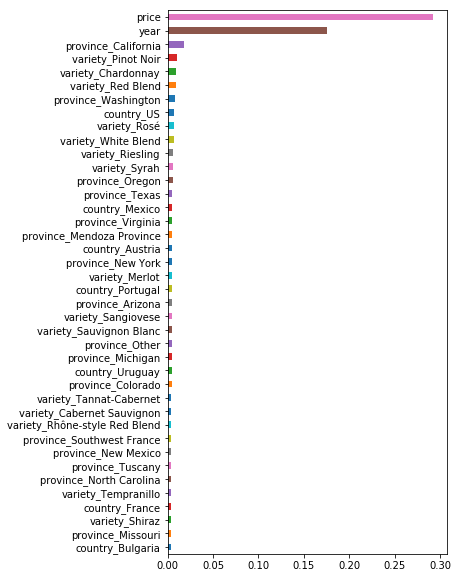

In [100]:
pd.Series(importances, index=X_train.columns).sort_values()[-40:].plot(kind='barh', figsize=(5,10));

In [101]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = importances
coefs_df['abs_coefs'] = np.abs(importances)

coefs_df.sort_values('abs_coefs', ascending=False).head(20)


,est_int,coefs,abs_coefs
0,price,0.292877,0.292877
1,year,0.175977,0.175977
95,province_California,0.018040,0.018040
897,variety_Pinot Noir,0.009840,0.009840
588,variety_Chardonnay,0.009614,0.009614
930,variety_Red Blend,0.008604,0.008604
452,province_Washington,0.007579,0.007579
42,country_US,0.007457,0.007457
948,variety_Rosé,0.007300,0.007300
1140,variety_White Blend,0.006719,0.006719


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? 

In [102]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:40]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:40]]]

# Train on the "best" model found from grid search earlier
model = (clone(best_model)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = model.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("r2 score on testing data: {:.4f}".format(r2_score(y_test, best_predictions)))
print("MSE on testing data: {:.4f}".format(mean_squared_error(y_test, best_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("r2 score on testing data: {:.4f}".format(r2_score(y_test, reduced_predictions)))
print("MSE on testing data: {:.4f}".format(mean_squared_error(y_test, reduced_predictions)))

Final Model trained on full data
------
r2 score on testing data: 0.4882
MSE on testing data: 4.9463

Final Model trained on reduced data
------
r2 score on testing data: 0.4749
MSE on testing data: 5.0745
